In [1]:
import config

In [2]:
import spotipy
import numpy as np
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
import pprint
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import IFrame, display
%store -r billbord_df




c_id = config.client_id
c_se = config.client_secret

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=c_id, client_secret=c_se))

## Functions 

In [3]:
def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id,market="GB")
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [4]:
## Playlist Id's fetching (insert query request)

def playlist_req(query, limit=5, type='playlist'):
    playlist = sp.search(q=query, limit=limit, type=type)

    pl_lst = []

    for list_ in playlist['playlists']['items']:
        pl_lst.append(list_['id'])
    return pl_lst

In [5]:
playlist_req("pop", limit=2)

['37i9dQZF1EQncLwOalG3K7', '6mtYuOxzl58vSGnEDtZ9uB']

In [6]:
def track_ids(query, limit_=5, type_='playlist'):
    
    # try:
    pl_lst = playlist_req(query, limit=limit_, type=type_)
    # except:
        # print('Issue with playlist request')
    
    track_id_list = []
    track_ids = []
    
    # try:
    for track in pl_lst:
        track_id_list.extend(get_playlist_tracks('Spotify', track))

    for i in track_id_list:
        track_ids.append(i['track']['id'])
    # except:
    #     print('Error in track id fetching')
        
    try:   
        chunk_size = 100
        track_ids_chopped = [track_ids[i:i+chunk_size] for i in range(0,len(track_ids), 100)]

        af_list = []

        for i in track_ids_chopped:
            af_list.extend(sp.audio_features(i))
        af_df = pd.DataFrame(af_list)
    except:
        print('Error in audio features fetching')


    

    return af_df
        

In [7]:
# Duplicate Dropper 

def dup_drop(df):
    dups = df.duplicated().sum()
    df.drop_duplicates(inplace=True)

    print(f'Dropped Duplicates: {dups}')

In [8]:
# Pickle file loader 

def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
        
    except FileNotFoundError: 
        print("File not found!") 


In [9]:
# Track player embeded

def play_song(track_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+track_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

In [10]:
## Drop list
drop = ['type', 'uri', 'track_href', 'analysis_url', 'time_signature']

## Importing playlists

In [11]:
rock = track_ids('rock', limit_=2)

In [12]:
jazz = track_ids('jazz', limit_=4)

In [13]:
rnb = track_ids('r&b', limit_=3)

In [14]:
afrobeat = track_ids('afrobeat', limit_=2)

In [15]:
blues = track_ids('blues', limit_=5)

In [16]:
dance = track_ids('dance', limit_=5)

In [17]:
hiphop = track_ids('hip hop', limit_=3)

In [18]:
rocknroll = track_ids('rocknroll', limit_=2)

In [19]:
techno = track_ids('techno', limit_=3)

In [20]:
rap = track_ids('rap', limit_=2)

In [21]:
german = track_ids("German 80's pop", limit_=2)

In [22]:
folk = track_ids('folk', limit_=3)

In [23]:
indie = track_ids('indie', limit_=3)

In [24]:
classic = track_ids('classic', limit_=3)

In [25]:
rocknroll = track_ids('rocknroll', limit_=4)

In [26]:
lst = [rock,jazz,rnb,blues,dance,afrobeat,hiphop,rocknroll,techno,rap,german,folk,indie,classic,rocknroll]

## Setup

In [27]:
df = pd.concat(lst, axis=0)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5875 entries, 0 to 479
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5875 non-null   float64
 1   energy            5875 non-null   float64
 2   key               5875 non-null   int64  
 3   loudness          5875 non-null   float64
 4   mode              5875 non-null   int64  
 5   speechiness       5875 non-null   float64
 6   acousticness      5875 non-null   float64
 7   instrumentalness  5875 non-null   float64
 8   liveness          5875 non-null   float64
 9   valence           5875 non-null   float64
 10  tempo             5875 non-null   float64
 11  type              5875 non-null   object 
 12  id                5875 non-null   object 
 13  uri               5875 non-null   object 
 14  track_href        5875 non-null   object 
 15  analysis_url      5875 non-null   object 
 16  duration_ms       5875 non-null   int64  
 

In [29]:
af_df= df.drop(['type', 'uri', 'track_href', 'analysis_url', 'time_signature'], axis=1)

In [30]:
af_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,0.741,0.697,0,-7.028,1,0.0277,0.066400,0.000023,0.133,0.774,116.109,2LawezPeJhN4AWuSB0GtAU,160133
1,0.556,0.864,3,-5.870,0,0.0584,0.009580,0.000000,0.209,0.400,105.143,60a0Rd6pjrkxjPbaKzXjfq,216880
2,0.515,0.430,7,-9.935,1,0.0372,0.009700,0.000133,0.129,0.104,91.844,70LcF31zb1H0PyJoS1Sx1r,238640
3,0.464,0.795,1,-9.267,1,0.0926,0.049300,0.002440,0.399,0.612,158.691,63T7DJ1AFDD6Bn8VzG6JE8,202267
4,0.417,0.934,7,-3.908,0,0.1190,0.000278,0.001500,0.132,0.287,127.066,2DlHlPMa4M17kufBvI2lEN,210240


In [31]:
## Dropping Duplicated rows

In [32]:
dup_drop(af_df)

Dropped Duplicates: 1081


In [33]:
X = af_df.select_dtypes(include='number')


In [34]:
X.shape

(4794, 12)

## Model Fitting 

In [35]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)


In [36]:
import warnings
warnings.filterwarnings('ignore')

kmeans = KMeans(n_clusters=8, random_state=1234)
kmeans.fit(X_scaled_df)
kmeans.inertia_


28549.354193004317

In [37]:
labels =kmeans.labels_

In [38]:
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index()

0     415
1     579
2     560
3     900
4     796
5     221
6     307
7    1016
dtype: int64

In [40]:
kmeans.inertia_

28549.354193004317

In [41]:
kmeans2 = KMeans(n_clusters=8,
                init="k-means++",
                n_init=4,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=7,
                algorithm="elkan",
                random_state=42)
kmeans2.fit(X_scaled_df)
print(kmeans2.inertia_)

28665.161362835726


## Choosing K

#### Elbow Method

Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 



Text(0.5, 1.0, 'Elbow Method showing the optimal k')

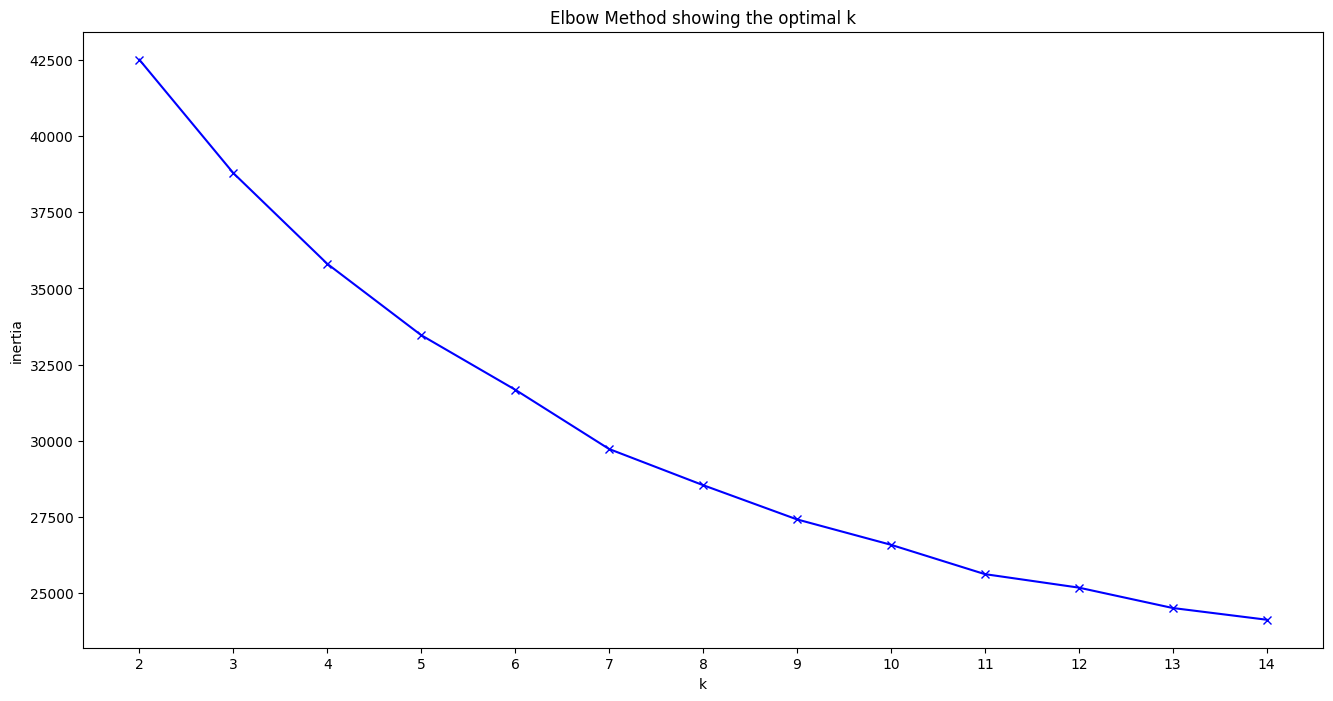

In [42]:
K = range(2, 15)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)


%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

##### Silohet Method

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

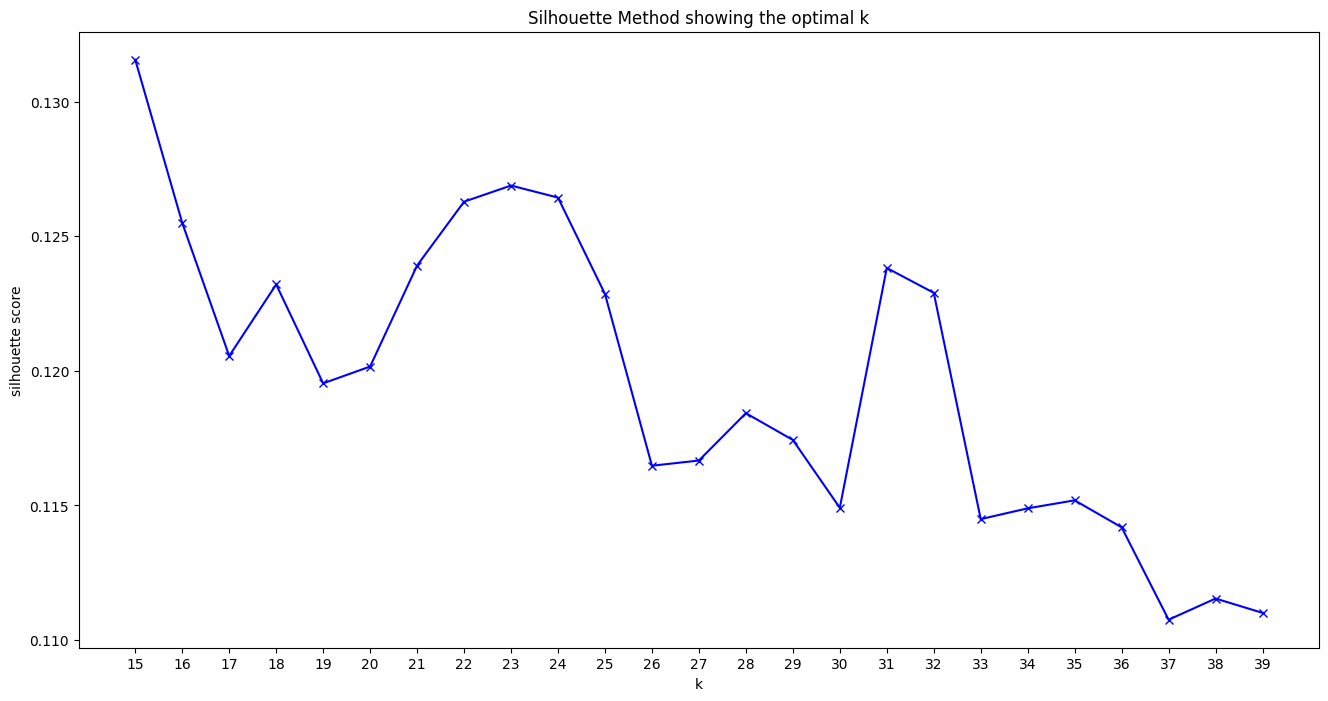

In [43]:
K = range(15, 40)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234, n_init='auto')
    kmeans.fit(X_scaled_df)
    
    filename = "kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [51]:
# Choice of model 

model_pickle = load('kmeans_33.pickle')

In [52]:
label = model_pickle.labels_

label

array([32, 16, 11, ..., 16,  7,  9])

In [75]:

filtered_af_df = af_df[af_df['cluster'] == 32]

filtered_af_df


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,cluster
0,0.741,0.697,0,-7.028,1,0.0277,0.06640,0.000023,0.1330,0.774,116.109,2LawezPeJhN4AWuSB0GtAU,160133,32
9,0.723,0.863,2,-7.890,1,0.0338,0.03830,0.031700,0.1280,0.931,136.302,2PzU4IB8Dr6mxV3lHuaG34,222813,32
28,0.550,0.917,0,-3.159,1,0.0638,0.00428,0.000000,0.1970,0.601,126.115,6TfBA04WJ3X1d1wXhaCFVT,177827,32
50,0.536,0.637,2,-7.774,1,0.0343,0.46700,0.000000,0.0838,0.798,115.240,50RwvvEKX5Q7AZt8FTAwIF,150133,32
57,0.654,0.929,1,-5.906,1,0.0998,0.04680,0.000000,0.0539,0.902,144.774,6KTv0Z8BmVqM7DPxbGzpVC,168840,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.752,0.684,0,-7.599,1,0.1500,0.09940,0.000000,0.0897,0.539,141.075,64UioB4Nmwgn2f4cbIpAkl,176440,32
337,0.620,0.930,1,-3.685,1,0.0374,0.00043,0.000000,0.0686,0.609,106.220,2g2a5kDeZexbUTD8abcvm6,190173,32
356,0.715,0.759,2,-5.125,1,0.0269,0.33700,0.000093,0.1830,0.875,121.480,5fZEzaBQnVr2kIom4DOrK1,185293,32
371,0.608,0.634,4,-11.240,1,0.0727,0.05680,0.006150,0.1160,0.840,147.515,72boGlgSwUK01n44O2tOCv,226947,32


In [62]:
af_df['cluster'] = label

In [68]:
af_df['cluster'].value_counts()

4     303
32    248
18    247
7     214
12    200
3     197
16    180
9     178
17    176
20    172
11    172
29    171
2     164
27    159
24    153
10    152
25    143
30    138
21    138
0     134
5     117
23    116
19    108
31    107
8      97
13     96
26     96
28     82
22     82
6      74
15     69
1      68
14     43
Name: cluster, dtype: int64

## User Interface

In [84]:
def song_searcher():   
    
    user_input = input().title()
    api_req = sp.search(q=user_input, limit=1, type='track')
    user_song = api_req['tracks']['items'][0]['id']
    # print(user_song)
    # print(user_input)
   
    
    if billbord_df['songs'].isin([user_input]).any():
        
            star = "*"
            hash_ = "#"

            for i in range(10):
                print(f'#{hash_*i}{" "*10}YOUR{star*i}SONG')
                
            
            display(play_song(user_song))
           
            for i in range(9,0, -1):
                print(f'{hash_*i}{" "*10}IS{star*i}HOT')
            print(f'\nThis song is the top 100 songs')
        
        
    else:
        
        display(play_song(user_song))
        
        print(f'Also recomended for you:\n{"*"*41}')
        # Audio Features of the user song
        song_ = pd.DataFrame(sp.audio_features(user_song))
        song_af = song_.select_dtypes(include='number')
        song_af.drop(['time_signature'], axis=1, inplace=True)
        # print(song_af)
        
        # print(song_af, type(song_af))
        
        #Scalling
        song_scaled = scaler.transform(song_af)
        song_scaled_df = pd.DataFrame(song_scaled, columns = song_af.columns)
        # song_scaled_df = df.drop(['type', 'uri', 'track_href', 'analysis_url', 'time_signature', 'id'], axis=1)
        # print(song_scaled_df)

        
        pred = model_pickle.predict(song_scaled_df)
        pred_ = int(pred[0])
        # print('cluster', pred)
        
        # Random selection from main af_df using pred
        song_reco_df = af_df[af_df['cluster'] == pred_].sample(3)
         
        
        # Embed recommendations
        for song in song_reco_df['id']:
            display(play_song(song))

        





In [86]:
song_searcher()


 blowin in the wind


Also recomended for you:
*****************************************
